### Keypoint detection demo

The main point of this notebook demonstrates the details of the Harris keypoint detector.  It ends with an example of using the SIFT class in OpenCV


In [1]:
import cv2         
import numpy as np
from matplotlib import pyplot as plt
import image_plot_utilities as ipu
import resize_img

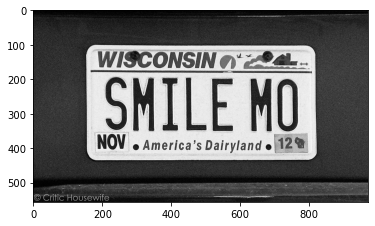

(800, 457)


In [2]:
'''  We'll test with license plate images from the web '''

# im_name = '../test_images/license_plates/florida-plate.jpg'
im_name = '../test_images/license_plates/wisconsin-plate.jpg'
im = cv2.imread(im_name, cv2.IMREAD_GRAYSCALE)
plt.gray()
plt.imshow(im)
plt.show()
# ipu.show_with_pixel_values(im)
im = resize_img.resize_img(im,800).astype(float)

The next block of code performs the steps of computing the Harris measure.

2 1 1
2 1 2


<Figure size 432x288 with 0 Axes>

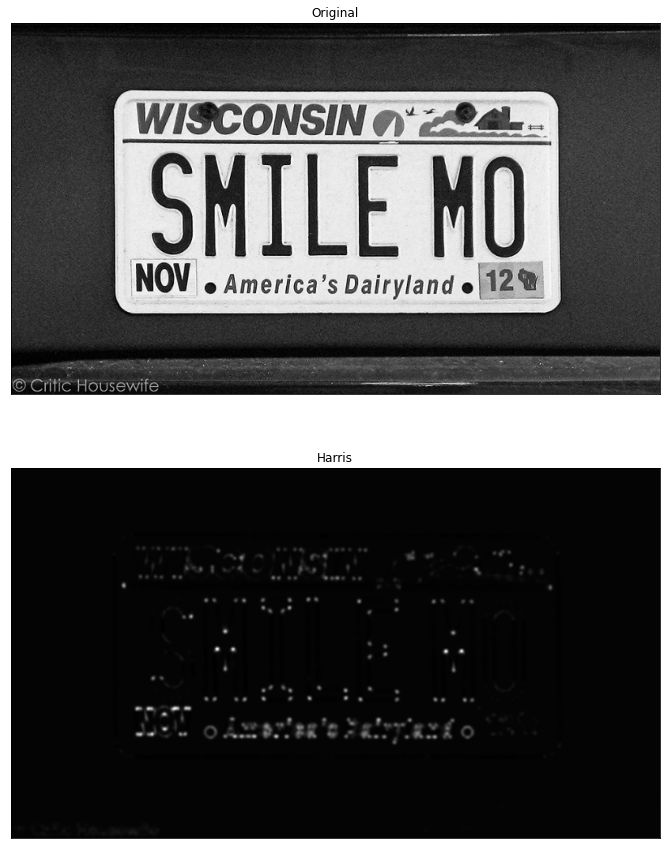

In [3]:
'''  Gaussian smoothing '''
sigma = 1
ksize = (4*sigma+1,4*sigma+1)
im_s = cv2.GaussianBlur(im.astype(np.float32), ksize, sigma)

'''  Derivative kernels '''
kx,ky = cv2.getDerivKernels(1,1,3)
kx = np.transpose(kx/2)
ky = ky/2

'''  Derivatives '''
im_dx = cv2.filter2D(im_s,-1,kx)
im_dy = cv2.filter2D(im_s,-1,ky)

''' Components of the outer product '''
im_dx_sq = im_dx * im_dx
im_dy_sq = im_dy * im_dy
im_dx_dy = im_dx * im_dy

''' Convolution of the outer product with the Gaussian kernel
    gives the summed values desired '''
h_sigma = 2*sigma
h_ksize = (4*h_sigma+1,4*h_sigma+1)
im_dx_sq = cv2.GaussianBlur(im_dx_sq, h_ksize, h_sigma)
im_dy_sq = cv2.GaussianBlur(im_dy_sq, h_ksize, h_sigma)
im_dx_dy = cv2.GaussianBlur(im_dx_dy, h_ksize, h_sigma)

''' Compute the Harris measure '''
kappa = 0.004
im_det = im_dx_sq * im_dy_sq - im_dx_dy * im_dx_dy
im_trace = im_dx_sq + im_dy_sq
im_harris = im_det - kappa * im_trace*im_trace

''' Show the gray scale image and the Harris image '''
ipu.plot_pics( [im, im_harris], 1, ['Original', 'Harris'] )

Now we come to the peak detection and non-maximum suppression step.  This requires use of a combination of thresholding, dilation, pixel-by-pixel comparison, and image multiplication.  See if you can understand the following steps.

Before normalization the minimum and maximum harris measures are -19615.146 1226656.5
im_harris_dilate float32
2
float32
255.0 0.0
2 1 1
2 1 2


<Figure size 432x288 with 0 Axes>

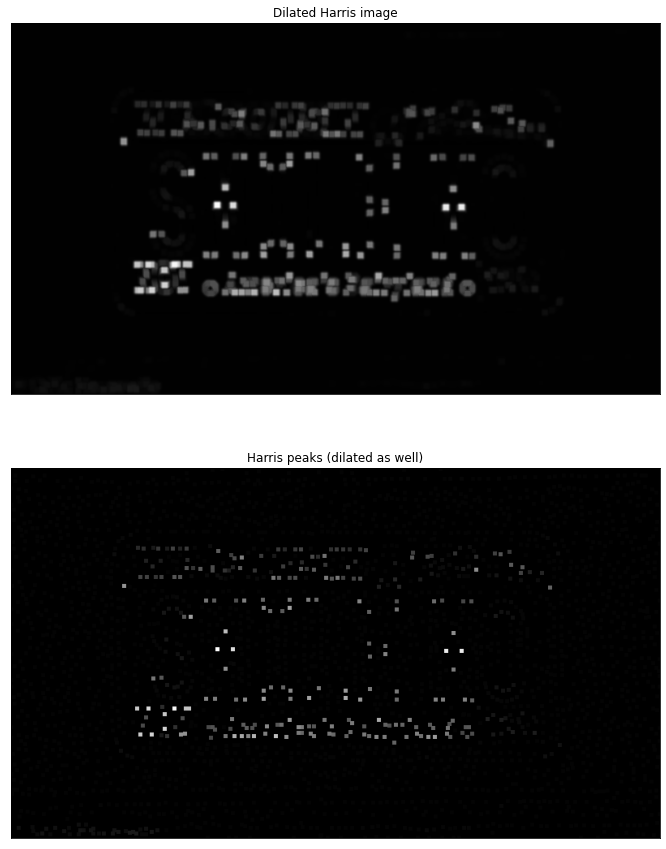

After NMS, there are 2675 peaks and this is 0.01 of the total number of pixels
And, the top, middle and bottom values are 255.0 4.0179596 2.7255564
The threshold to keep only the top 25.0 percent of the peaks is 4.1


In [4]:
''' Renormalize the intensities into the 0..255 range '''
i_min = np.min(im_harris)
i_max = np.max(im_harris)
print("Before normalization the minimum and maximum harris measures are",
     i_min, i_max)
im_harris = 255 * (im_harris - i_min) / (i_max-i_min)

'''
Apply non-maximum thresholding using dilation. Comparing the dilated image to the
Harris image will preserve only those locations that are peaks.
'''
max_dist = 2*sigma
kernel = np.ones((2*max_dist+1, 2*max_dist+1), im_harris.dtype)
im_harris_dilate = cv2.dilate(im_harris, kernel)
print("im_harris_dilate", im_harris_dilate.dtype)
print(len(np.where(im_harris < im_harris_dilate)))

im_harris[np.where(im_harris < im_harris_dilate)] = 0
print(im_harris.dtype)
print(np.max(im_harris), np.min(im_harris))

ipu.plot_pics([im_harris_dilate, cv2.dilate(im_harris, kernel)], 
            1, ['Dilated Harris image', 'Harris peaks (dilated as well)'] )

'''
Get the normalized Harris measures of the peaks
'''
peak_values = im_harris[np.where(im_harris>0)]
peak_values = np.sort(peak_values, axis=None)
print("After NMS, there are %d peaks and this is %.2f of the total number of pixels"
      % (len(peak_values), len(peak_values)/im_harris.size))
print("And, the top, middle and bottom values are",
      peak_values[-1], peak_values[len(peak_values)//2], peak_values[0])

'''
Keep only those that are in the top fraction.
'''
threshold_frac = 0.25
threshold_index = int((1-threshold_frac)*len(peak_values))
threshold = peak_values[threshold_index]
print("The threshold to keep only the top %.1f percent of the peaks is %.1f"
      % (threshold_frac*100, threshold))
_, im_harris_thresh = cv2.threshold(im_harris.astype(np.uint8), threshold,
                                     1, cv2.THRESH_BINARY)


As the last step we need to extract the Harris keypoints and convert them to OpenCV KeyPoint objects.  Once we do this, we can display the keypoints on the original image. 

We have 451 keypoints.
1 1 1


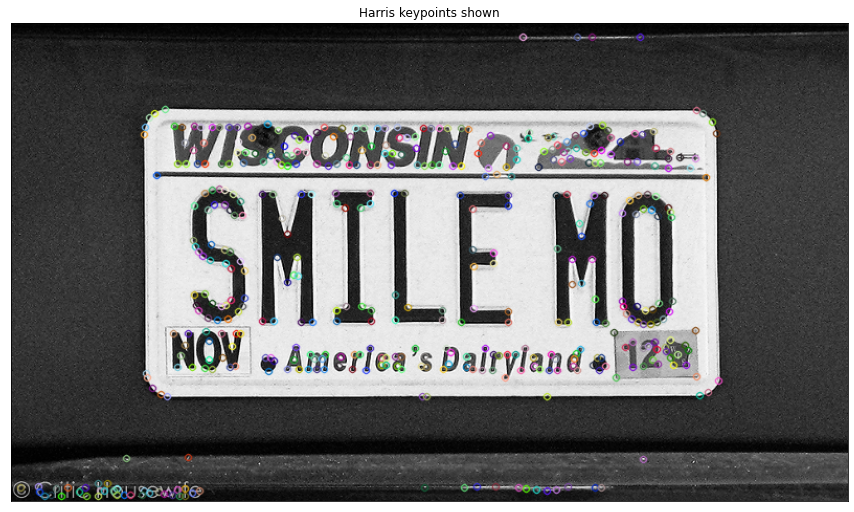

In [5]:
'''  Extract all indices '''
indices = np.where(im_harris_thresh > 0)
ys,xs = indices[0],indices[1]   # rows and columns

''' Put them into the keypoint list '''
kp_size = 4*sigma
harris_keypoints = [
    cv2.KeyPoint(float(xs[i]), float(ys[i]), kp_size)
    for i in range(len(xs))
]

print("We have", len(harris_keypoints), "keypoints.")

out_img = cv2.drawKeypoints( im.astype(np.uint8), harris_keypoints, None)
ipu.plot_pics( [out_img], 1, ['Harris keypoints shown'] )


#### About SIFT: 

The SIFT algorithm was patented, but despite the patent, an implementation of SIFT was part of OpenCV for many years.  In 2014 or so it was moved to the "contrib" package and then not compiled with the default distribution. It was still available for compilation and installation from source for academic and non-commercial uses.  With the expiration of the patent in March 2020, SIFT is back in the OpenCV distribution. Therefore, please be sure your OpenCV version is up to date.

In [ ]:
"""
This code shows the results of the SIFT keypoint detector.
"""
sift_alg = cv2.SIFT_create()
sift_kp = sift_alg.detect(im.astype(np.uint8),None)
print(len(sift_kp), "keypoints detected")
sift_out_img = cv2.drawKeypoints(im.astype(np.uint8), sift_kp, None)
ipu.plot_pics( [sift_out_img], 1, ['SIFT keypoints shown'] )


#### ORB instead:

Following the publication of SIFT, especially the 2004 IJCV version, there was an explosion of research on alternative algorithms. One of these, ORB, was developed and published in 2011 at ICCV, by the original designers of OpenCV. We will not consider too much the details of how ORB works, but will employ the fact that it does produce both keypoint locations and descriptors. For now, we will only look at the ORB detection results.  Many other keypoint and descriptor algorithms have been contributed to OpenCV as can be seen in the class hierarchy for cv::Feature2D https://docs.opencv.org/4.1.1/d0/d13/classcv_1_1Feature2D.html

In [ ]:
im_name = '../test_images/license_plates/wisconsin-plate.jpg'
im = cv2.imread(im_name, cv2.IMREAD_GRAYSCALE)
im = resize_img.resize_img(im, 800)

num_features = 1000
orb = cv2.ORB_create(num_features)        # See method doc for other parameters
kp, des = orb.detectAndCompute(im, None)  # The None argument is where a binary mask could be

print("There are %d keypoints and descriptors, and each descriptor is length %d"
      % (len(kp), len(des[0])))

print('\nHere the first 10 keypoints')
for k in kp[:10]:
    print(k.response, k.pt, k.angle, k.size)

out_im = cv2.drawKeypoints(im, kp, None)
ipu.plot_pics( [out_im], 1, ['ORB keypoints shown'] )
